# Minimal working example of a dynamic PCA Layer for TensorFlow

In [13]:
import tensorflow as tf
class PCALayer(tf.keras.layers.Layer):
    n_components : int = None   # No dimension reduction with None
    
    def __init__(self, inverse_layer : bool, **options):
        self.inverse_layer = inverse_layer
        self._fitted = False
        options['dynamic']   = True  # Is dynamic
        options['trainable'] = False # but not trainable
        super().__init__(**options)  # further Layer init
    
    def fit(self, XTrain : tf.Tensor) -> None:
        """
        Calculates the SVD, afterwards the PCA can be applied
        """
        self.mean = tf.reduce_mean(XTrain, axis=0)
        XTrain = tf.subtract(XTrain, self.mean)     # Centering of data
        # Sidenote, tf, numpy and scipys svds can be different
        S, U, V = tf.linalg.svd(XTrain, full_matrices=False)
        V = tf.transpose(V)
        # Store singular values and transformation matrix V
        self.S, self.V = S, V  # TODO: Should be done as tf weights
        self._fitted = True       
    
    def transform(self, X : tf.Tensor) -> tf.Tensor:
        """
        Applies the PCA transformation with choosen dimension
        which is set by the attribute n_components.
        Output shape: (X.shape[0], self.n_components)
        """
        X = tf.subtract(X, self.mean) # Center data
        # Transform with submatrix of V to choosen dimension
        Xk = tf.matmul(X, tf.transpose(self.V[:self.n_components, :]))
        return Xk
        
    def inverse_transform(self, Xk : tf.Tensor) -> tf.Tensor:
        """
        Reverse the PCA transformation from Xk with dimension k
        to original dimension n.
        Output shape: (Xk.shape[0], self.S.shape[0])
        """
        X = tf.matmul(Xk, self.V[:Xk.shape[-1], :]) # Always returns to full dimension of V
        X = X + self.mean                           # Reverse the centering
        return X
        
    def call(self, input : tf.Tensor) -> tf.Tensor:
        """
        This function is called when data passes the layer
        """
        if not self._fitted :   # No action if not fitted
            return input
        if self.inverse_layer:  # Reverse transformation
            return self.inverse_transform(input)
        return self.transform(input) # reduce dimension with PCA
    
    def compute_output_shape(self, input_shape : tf.Tensor) -> tf.Tensor:
        """
        This method is not needed if TensorFlow runs eagerly
        """
        if not self._fitted:
            return input_shape
        if not self.inverse_layer:
            return tf.TensorShape([input_shape[0], self.n_components or input_shape[1:]])
        return tf.TensorShape([None, self.S.shape[0]])

        

# Possible usage

## Autoencoder setup and first training

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, BatchNormalization, UpSampling2D, Input

# Load and scale data
(XTrain, YTrain), (XTest, YTest) = tf.keras.datasets.mnist.load_data()
input_shape=XTrain.shape[1:] # 28x28 here
XTrain = XTrain.astype('float32') / 255.
XTest = XTest.astype('float32') / 255.

# Define PCA Layers
pca_transform_layer = PCALayer(inverse_layer=False)
pca_inverse_layer = PCALayer(inverse_layer=True)

# Define encoder and decoder
encoder = Sequential(layers=[
    Reshape((-1, 28,28,1)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3,3), strides=(2,2), activation="relu"),
    Conv2D(64, kernel_size=(3,3), strides=(2,2), activation="relu"),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    pca_transform_layer
    ])

decoder = Sequential(layers=[
    pca_inverse_layer,
    Dense(7**3, activation="relu"),
    Reshape((7, 7, 7)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
    UpSampling2D(),
    Conv2D(128, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
    UpSampling2D(),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
    Conv2D(1, kernel_size=(3,3), strides=(1,1), activation="sigmoid", padding='same'),
    Reshape((28, 28))
    ])

# Define and train autoencoder
model = Sequential(layers=[encoder, decoder])
model.compile(optimizer='adam', loss='binary_crossentropy')

# %%% Training
model.fit(XTrain, XTrain, batch_size=128, epochs=2,
         validation_data=(XTest, XTest)) 

# Encode Training data for PCA
encoded = encoder.predict(XTrain)    # <--- Note the memory usage

Epoch 1/2
469/469 [==============================] - 41s 86ms/step - loss: 0.1382 - val_loss: 0.0843
Epoch 2/2
469/469 [==============================] - 40s 85ms/step - loss: 0.0786 - val_loss: 0.0752


## Output sample

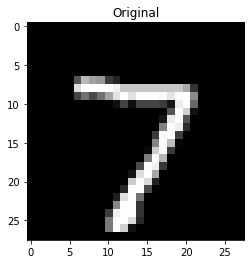

In [15]:
import matplotlib.pyplot as plt
plt.title("Original")
plt.imshow(XTest[:1][0], cmap='gray')
plt.show()

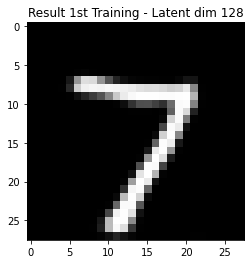

In [16]:
plt.title("Result 1st Training - Latent dim 128")
plt.imshow(model.predict(XTest[:1])[0], cmap='gray')
plt.show()

## Apply PCA and define dynamic latent dimension

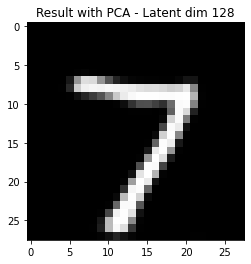

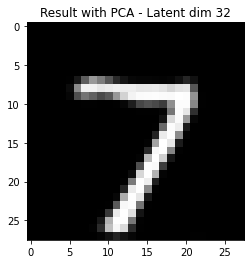

In [17]:
# Fit PCA
# Note rerunning this cell yields not the same result
# as the pca_layer is part of the encoder
encoded = encoder.predict(XTrain)  # <--- Encode the data, Note the memory usage
pca_transform_layer.fit(encoded)
pca_inverse_layer.fit(encoded)    # <--- Here you see the problem of this mwe. pca needs to be done twice
del encoded
pca_transform_layer.n_components = None # <-- Full latent shape

plt.title("Result with PCA - Latent dim 128")
plt.imshow(model.predict(XTest[:1])[0], cmap='gray')
plt.show()

pca_transform_layer.n_components = 32 # <-- Define a custom latent layer size

plt.title("Result with PCA - Latent dim 32")
plt.imshow(model.predict(XTest[:1])[0], cmap='gray')
plt.show()

## Possible retraining to improve results at a lower dimension

Epoch 1/2
469/469 [==============================] - 40s 86ms/step - loss: 0.0802 - val_loss: 0.0808
Epoch 2/2
469/469 [==============================] - 42s 89ms/step - loss: 0.0775 - val_loss: 0.0760


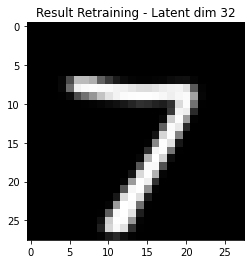

In [18]:
# Possible Retraining
model.fit(XTrain, XTrain, batch_size=128, epochs=2, 
          validation_data=(XTest, XTest)) # <--- Adjust with appropriate data

plt.title("Result Retraining - Latent dim 32")
plt.imshow(model.predict(XTest[:1])[0], cmap='gray')
plt.show()